Brain states transitions in response to working memory training
==================================================================

Analyses performed by Karolina Finc & Justyna Kuk, 
*Centre for Modern interdisciplinary Technologies, Nicolaus Copernicus University in Toruń*

Last edited: 08-05-2019

--------------

The goal of this analysis is to examine the effects of working memory training on *time-resolved brain state dynamics* examined in the trained task and the resting-state. Does working memory training affects brain state distribution in the task? 

We used unsupervised machine learning approach to cluster dual n-back and resting-state fMRI time-series into discrete brain states (see Chen et al., 2015; Cornblath et al., 2018). We hypothesize that:
- The brain states fluctuation will differ after working memory training especially in the states related to default mode and frontoparietal systems activity. 
- Training-related changes in brain states dynamics will be more visible during the trained task than the resting state.
- Individual characteristics of brain states fluctuations will be associated to individual behavioral differences in training progress.


Step 1: Timeseries preparation
----------

Prior to running clustering the time-series into discrete brain stets, all timeseries were concatenated into large $N \times P$ array containing $N$ observation and $P$ features. The length of $N$ was equal to 25800 as a result of concatenating 4 sessions of dual n-back data (340 time-points) and resting state data (305 time-points) of 44 subjects. The length of $P$ was equal 264 and represented the mean signal extracted from each brain areas of Schaefer et al. (2019) brain parcellation.

By this procedure we ensured the correspondence of brain states labels across subjects, sessions and tasks.

(for now, we just testing code on 10 subjects)

In [2]:
#from nilearn import datasets
import numpy as np

n_sub = 10      # Select number of subjects 

# power = datasets.fetch_coords_power_2011()
# coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

# Loading time-series data
data = np.load("LB_dualnback_timeseries.npy")
data2 = np.load("LB_rest_timeseries.npy")

time_series_nback = data[0:n_sub]
time_series_rest = data2[0:n_sub]

print(f'Original dualnback data shape: {time_series_nback.shape}')
print(f'Original rest data shape: {time_series_rest.shape}')

Original dualnback data shape: (10, 4, 340, 264)
Original rest data shape: (10, 4, 305, 264)


In [3]:
# Concatenating time-series
dim_nback = time_series_nback.shape[0]*time_series_nback.shape[1]*time_series_nback.shape[2]
dim_rest =  time_series_rest.shape[0]*time_series_rest.shape[1]*time_series_rest.shape[2]

t_vector_nback = time_series_nback.reshape(dim_nback, time_series_nback.shape[3])     #all 46 subcjects in one vector
t_vector_rest = time_series_rest.reshape(dim_rest, time_series_nback.shape[3])

In [4]:
#one vector for both rest and nback time-series:


dim = dim_nback+dim_rest

t_vector = np.zeros((dim, time_series_nback.shape[3]))
t_vector[0:dim_nback] = t_vector_nback
t_vector[dim_nback:] = t_vector_rest

print(f'Shape of dualnback timeseries: {t_vector_nback.shape}')
print(f'Shape of rest timeseries: {t_vector_rest.shape}')
print(f'Shape of all timeseries: {t_vector.shape}')

Shape of dualnback timeseries: (13600, 264)
Shape of rest timeseries: (12200, 264)
Shape of all timeseries: (25800, 264)


Step 2: Clustering the timeseries into brain states
----------------------

To discover main brain states existing in time-series we performed 500 repetitions of $k$-means clustering from $k$ = 2 to $k$ = 18 using Euclidean distance as a measure of similarity. 

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_k = 18
brain_states = np.zeros((max_k-1,t_vector.shape[0]))
silhouette = np.zeros((max_k-1))

for k in range(max_k-1):
    print(f'Clustering for k = {k+2}')
    kmeans = KMeans(n_clusters=k+2, n_init=10).fit(t_vector) # Change to 500 later
    kmeans_predict = kmeans.fit_predict(t_vector)
    brain_states[k,:] = kmeans.labels_
    silhouette[k] = silhouette_score(t_vector, kmeans_predict)

Clustering for k = 2
Clustering for k = 3
Clustering for k = 4
Clustering for k = 5
Clustering for k = 6
Clustering for k = 7
Clustering for k = 8
Clustering for k = 9
Clustering for k = 10
Clustering for k = 11
Clustering for k = 12
Clustering for k = 13
Clustering for k = 14
Clustering for k = 15
Clustering for k = 16
Clustering for k = 17
Clustering for k = 18


In [7]:
import numpy as np
np.save("brain_states.npy", brain_states)
np.save("silhouette_score.npy", silhouette)

In [9]:
#clusters for each subject:
n_clusters = 5

labels_nback = np.zeros((n_sub,n_clusters,time_series_nback.shape[1]*time_series_nback.shape[2]))
x = time_series_nback.shape[1]*time_series_nback.shape[2]*10

for k in range(n_clusters):
    labels_nback[:,k,:] = np.split(brain_states[k,0:x], n_sub)        #split for n subjects

labels_rest = np.zeros((n_sub, n_clusters, time_series_rest.shape[1]*time_series_rest.shape[2]))

for k in range(n_clusters):
    labels_rest[:,k,:] = np.split(brain_states[k,x:], n_sub)


In [11]:
n = 5
import pandas as pd
data = pd.DataFrame()

for k in np.arange(n):
    x = np.unique(labels_nback[:,k,:],return_counts=True )
    y = np.unique(labels_rest[:,k,:],return_counts=True )
    tasks = {"rest":y, "nback":x}
    for task in tasks.keys():
        if task=='rest':
            a = labels_rest.shape[2]*10
        else:
            a = labels_nback.shape[2]*10
        data = pd.concat([data,pd.DataFrame({'type':task,
                                             'n_clusters':k+1, 
                                             'cluster':tasks[task][0],
                                             'count':tasks[task][1]/a})])
        
data

,type,n_clusters,cluster,count
0,rest,1,0.0,0.508934
1,rest,1,1.0,0.491066
0,nback,1,0.0,0.508824
1,nback,1,1.0,0.491176
0,rest,2,0.0,0.231967
1,rest,2,1.0,0.254508
2,rest,2,2.0,0.513525
0,nback,2,0.0,0.255441
1,nback,2,1.0,0.275000
2,nback,2,2.0,0.469559


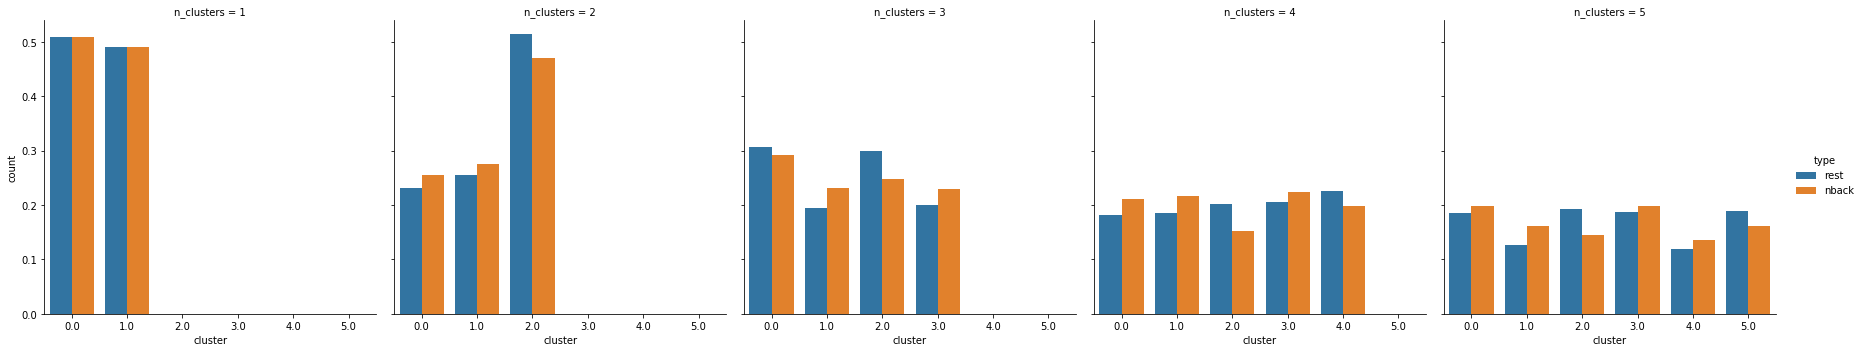

In [13]:
import seaborn as sns
sns.catplot(x = 'cluster',y = 'count',hue = 'type', data = data, kind = 'bar', col = 'n_clusters')

Step 3: Selecting k size based on silhouette score and absent states
-------------------------------------------------------------------------
To identify the optimal number of clusters we use silhouette score....

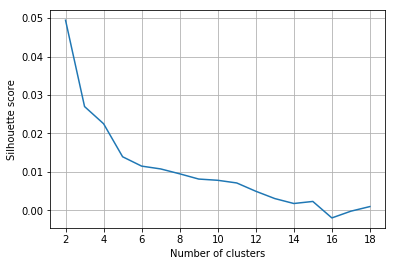

In [80]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting Silhouette score
plt.plot(np.arange(2,19), silhouette)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [22]:
import numpy as np

brain_states = np.load('brain_states.npy')

bs_dualnback = brain_states[:, :t_vector_nback.shape[0]]
bs_rest = brain_states[:, t_vector_nback.shape[0].shape[0]:]

sub_ses_bs_dualnback = bs_dualnback.reshape(brain_states.shape[0], time_series_nback.shape[2], n_sub, time_series_nback.shape[1])
sub_ses_bs_rest = bs_rest.reshape(brain_states.shape[0], time_series_rest.shape[2], n_sub, time_series_nback.shape[1])

print(sub_ses_bs_dualnback.shape)
print(sub_ses_bs_rest.shape)

(17, 340, 10, 4)
(17, 305, 10, 4)


In [84]:
from functions import absent_states

absent_states = absent_states(sub_ses_bs_dualnback)
absent_states.head()

,subject,session,k,absent
0,sub-01,ses-1,2,0
0,sub-01,ses-1,3,0
0,sub-01,ses-1,4,0
0,sub-01,ses-1,5,0
0,sub-01,ses-1,6,0


Step 4: Split-halves validation for k = X
-------------------------------------------------------------------------

We also split our sample into two equal partitions 500 times and performed k-means clustering separately on each half of the dataset. We then matched clusters by computing the correlation between both sets of centroids, and then by reordering the clusters based on the maximum correlation value for each cluster.

In [28]:
dim = int(t_vector.shape[0]/2)
n_rep = 10                        #chage to 500 later!

train_series = np.zeros((n_rep,dim,t_vector.shape[1]))
test_series = np.zeros((n_rep,dim,t_vector.shape[1]))

In [29]:
from sklearn.model_selection import train_test_split

for i in range(n_rep):       
    X_train, X_test = train_test_split(t_vector, test_size=0.5)
    train_series[i,:,:] = X_train
    test_series[i,:,:] = X_test

In [30]:
from sklearn.cluster import KMeans
import pandas as pd
from scipy.stats import pearsonr

n_clusters = 5
correlation_matrix = np.zeros((n_rep,n_clusters,n_clusters)) 

for sub in range(n_rep):     
    train_kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(train_series[sub,:,:])
    test_kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(test_series[sub,:,:])
    x = train_kmeans.cluster_centers_
    y = test_kmeans.cluster_centers_
    for k in range(n_clusters):
        for j in range(n_clusters):
            correlation_matrix[sub,k,j] = pearsonr(x[k],y[j])[0]

In [32]:
correlation_matrix_sort = np.sort(correlation_matrix)
max_values = np.zeros((n_rep,n_clusters))

for i in range(n_rep):
    max_values = correlation_matrix_sort[i,:,-1]
    mean_max_values = (correlation_matrix_sort[i,:,-1]).mean


Pearson correlation values, pair number 8 : [0.97610775 0.9884205  0.97068792 0.96439068 0.98636513]
0.9771943972367818


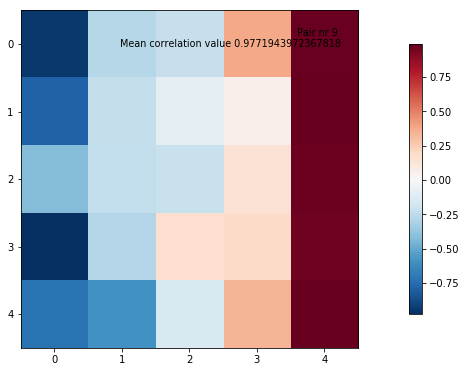

In [77]:
from nilearn import plotting

num = 8

print(f"Pearson correlation values, pair number {num} : {correlation_matrix_sort[num,:,-1]}")
print(correlation_matrix_sort[num,:,-1].mean())

plotting.plot_matrix(correlation_matrix_sort[num,:,:], title = f"Pair nr {num+1} \n Mean correlation value {correlation_matrix_sort[num,:,-1].mean()}")

Step 5: Correlating cluster labels with well-known large-scale networks
-------------------------------------------------------------------------
We calculate corralation between mean of the time-series for each cluster and modules using Pearson correlation.

In [44]:
from functions import k_time_series
mean_matrix = k_time_series(5,t_vector)

/home/connectomics/anaconda3/lib/python3.6/site-packages/nilearn/plotting/displays.py:1752: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


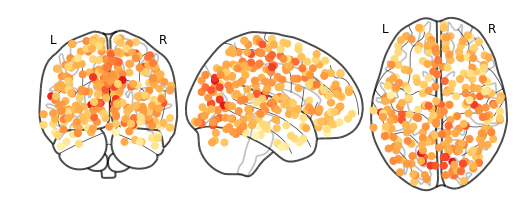

In [45]:
# -- loading Power ROIs coordinates

import matplotlib.pyplot as plt


colors = plt.cm.YlOrRd(mean_matrix[4])

from nilearn import datasets
from nilearn import plotting

power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T
plotting.plot_connectome(np.zeros((264,264)),power_coords,node_color = colors, edge_vmin=-0.8, edge_vmax=0.85)

For 0 cluster:
Max = 0.36624205949485966 with VIS
Min = -0.338092191476991 with UNC 

For 1 cluster:
Max = 0.3556658254353039 with UNC
Min = -0.3164035585046837 with VIS 

For 2 cluster:
Max = 0.35855235265868557 with VIS
Min = -0.6462022243972957 with DM 

For 3 cluster:
Max = 0.6195476569780628 with FP
Min = -0.359979709693574 with VIS 

For 4 cluster:
Max = 0.7676846850618635 with DM
Min = -0.2574052450608987 with FP 



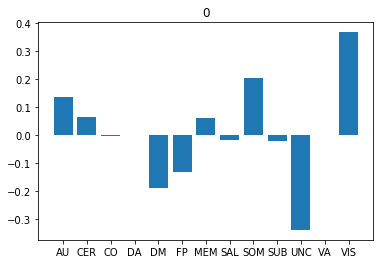

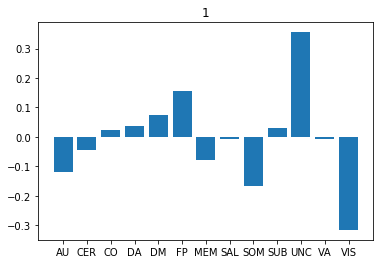

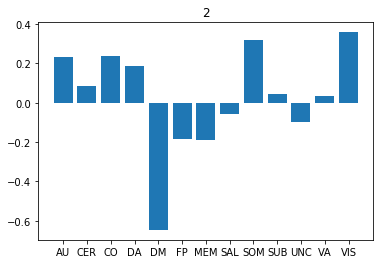

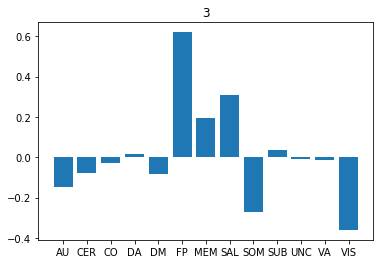

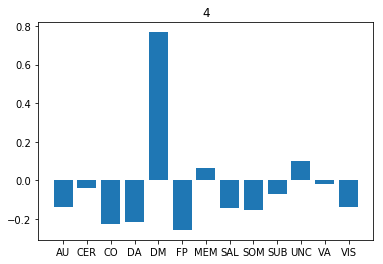

In [46]:
import functions
functions.compare(t_vector,5)

Step 5: Calculating persistence probablilities, transition probablilities, dwell times for each subject
-------------------------------------------------------------------------

We calculated several measures using brain states labels, to better describe brain states dynamics. 
For each subject, session, and task we calculated state's: 

- **dwell times** - percentage of timepoints in each run classified as specific state
- **transition probability** - probability of the transition from state $i$ to state $j$ given the current state $i$ divided by the sum of occurencies of $i$, resulting in $S\times S$ probability matrix $P_{ij}$, where S is equal to number of examined states.
- **persistence probability** - probability of the remaining in the same state. Diagonal elements of $P_{ij}$.

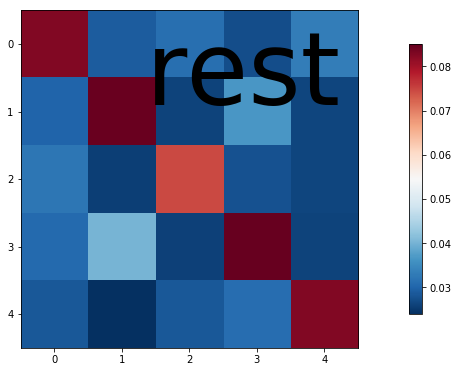

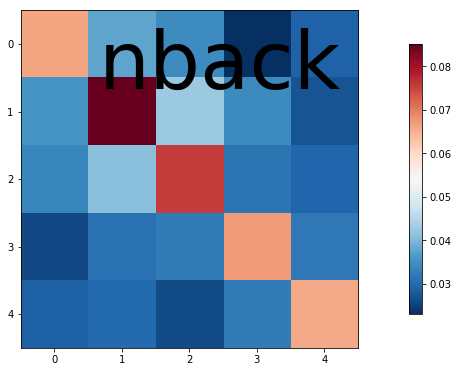

In [47]:
#transition probability

from nilearn import plotting
import functions 

t_nback = time_series_nback.reshape(n_sub,time_series_nback.shape[1]*time_series_nback.shape[2],time_series_nback.shape[3])    #for each subject
t_rest = time_series_rest.reshape(n_sub,time_series_rest.shape[1]*time_series_rest.shape[2],time_series_nback.shape[3])

plotting.plot_matrix(functions.multiple_transition(5,t_rest).mean(axis=0), title = "rest")
plotting.plot_matrix(functions.multiple_transition(5,t_nback).mean(axis=0), title = "nback")

Step 6: Groups/sessions comparison
-------------------------------------------------------------------------
Description

In [ ]:
# Code here